# Examining Decay of Linkage Disequilibrium as a Function of Physical Distance
This notebook demonstrates examining the decay of linkage disequilibrium (LD) as a function of physical distance between variants, using LD data stored as publicly accessible BigQuery datasets. Specifically, we will work with LD calculated on the [1000 Genomes Phase 3](http://www.nature.com/nature/journal/v526/n7571/full/nature15393.html) variants. The source variants were imported to Google Genomics and then LD calculations were performed and the resulting dataset exported to BigQuery using pipelines in the https://github.com/googlegenomics/linkage-disequilibrium project.

If you want to explore more linkage disequilibrium samples, see https://github.com/googlegenomics/linkage-disequilibrium/tree/master/datalab. For general genomics examples, see https://github.com/googlegenomics/datalab-examples. You can import them into your Datalab instance by uploading them while on the notebook list page.

In [31]:
import gcp.bigquery as bq
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

The [initial LD exploration Datalab](https://github.com/googlegenomics/linkage-disequilibrium/blob/master/datalab/Exploring_Linkage_Disequilibrium_Data.ipynb) indicated that LD is best analyzed on a population-specific level. Consequently, we load data for subpopulations directly.

In [32]:
# Get references to the BigQuery tables of linkage disequilibrium
# in the five superpopulations of the 1000 Genomes Project
# (http://www.1000genomes.org/faq/which-populations-are-part-your-study):
# AMR: Admixed American
# AFR: African
# EUR: European
# SAS: South Asian
# EAS: East Asian
populations = {
  "AFR": ["ACB", "ASW", "ESN", "GWD", "LWK", "MSL", "YRI"],
  "AMR": ["CLM", "MXL", "PEL", "PUR"],
  "EAS": ["CDX", "CHB", "CHS", "JPT", "KHV"],
  "EUR": ["CEU", "FIN", "GBR", "IBS", "TSI"],
  "SAS": ["BEB", "GIH", "ITU", "PJL", "STU"],
}

sub_to_super = {sub: super for super, subs in populations.items() for sub in subs}

def get_ld_tablename(population):
  """Returns the name of the BigQuery table with the publicly-available LD data."""
  return "genomics-public-data:linkage_disequilibrium_1000G_phase_3.%s" % population

tables = {}
for superpopulation in populations:
  subpopulations = populations[superpopulation]
  
  for subpopulation in subpopulations:
    # Only load the subpopulations for this analysis.
    tables[subpopulation] = bq.Table(get_ld_tablename(subpopulation))

## Linkage disequilibrium decay
We can investigate the extent to which linkage disequilibrium decays as a function of distance between variants, in a manner similar to that performed in [Extended Data Figure 10](http://www.nature.com/nature/journal/v526/n7571/fig_tab/nature15393_SF10.html) of the [1000 Genomes Phase 3](http://www.nature.com/nature/journal/v526/n7571/full/nature15393.html) paper.

The query below can be used to collect aggregate LD decay information genome-wide.

In [33]:
%%sql --module ld_decay
SELECT
  distance,
  count(*) AS num_chroms,
  AVG(rsquared) AS mean_rsquared,
  STDDEV_SAMP(rsquared) AS stdev_rsquared
FROM
  (SELECT
     CEIL((tstart - qstart) / $bin_size) AS distance,
     corr * corr AS rsquared
   FROM $all_ld_table
   WHERE qstart < tstart)
GROUP BY distance
ORDER BY distance

In [34]:
# Create a dictionary keyed by population with value a DataFrame of r^2 values
# binned by distance from the query variant.
decay = {}
bin_size = 5000
for population, table in tables.iteritems():
  result = bq.Query(ld_decay,
                    all_ld_table=table,
                    bin_size=bin_size).to_dataframe()
  result["distance"] *= bin_size
  decay[population] = result.loc[result["distance"] <= 1000000]

In [35]:
def plot_ld_decay(decay_dict, max_distance=200000):
  """Plots a figure of LD decay in all populations."""
  fig = plt.figure()
  ax = fig.add_subplot(111)
  handles = []
  colormaps = {"AFR": matplotlib.cm.get_cmap("YlOrBr"),
               "AMR": matplotlib.cm.get_cmap("Reds"),
               "EAS": matplotlib.cm.get_cmap("Greens"),
               "EUR": matplotlib.cm.get_cmap("Blues"),
               "SAS": matplotlib.cm.get_cmap("Purples")}
  
  # Plot data so that the legend groups by superpopulation,
  # ordered from the highest to lowest LD.
  pop_order = [sub_to_super[k] for k, v in sorted(decay.items(),
                                                  key=lambda x: max(x[1]["mean_rsquared"]),
                                                  reverse=True)]

  population_plot_order = []
  for superpop in pop_order:
    if superpop not in population_plot_order:
      population_plot_order.append(superpop)
  
  labels = []
  for superpopulation in population_plot_order:
    subpopulations = populations[superpopulation]
    for i, subpopulation in enumerate(subpopulations):
      df = decay[subpopulation]
      df = df.loc[df["distance"] <= max_distance]
      color = colormaps[superpopulation](1 - (i / 8.))
      lp, = ax.plot(df["distance"], df["mean_rsquared"],
                    label=subpopulation,
                    color=color)
                   
      handles.append(lp)
      labels.append(subpopulation)
  plt.legend(handles, labels,
             loc='center left',
             bbox_to_anchor=(1.1, 0.5))
  ax.set_axis_bgcolor("white")
  ax.grid(False)
  ax.set_xlabel("Distance (bp)")
  ax.set_ylabel("Mean r^2")

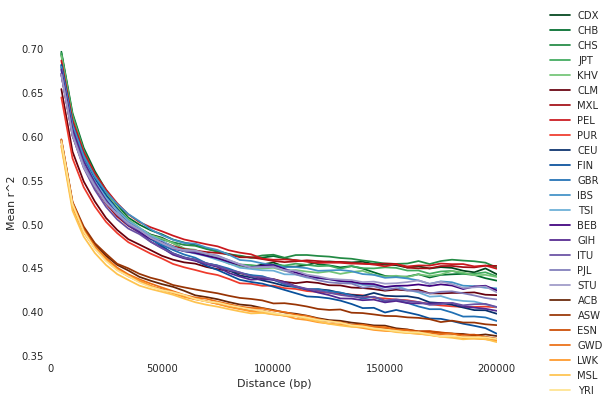

In [36]:
plot_ld_decay(decay)

The plots show a decay of LD strength as distance between variants increases. As expected, the rate of LD decreases as physical distance between variants increases. Also, the level of LD appears lower in the African populations than the other populations, similar to the observation made in the [1000 Genomes paper](http://www.nature.com/nature/journal/v526/n7571/fig_tab/nature15393_SF10.html). However, the curves plateau at an r^2 minimum between 0.35 and 0.5.

The reason the r^2 values reported here are very different from the 1000 Genomes LD decay is that this plot is calculating average LD decay between variant pairs but is restricting to only pairs for which r^2 >= 0.16. In other words, this shows LD decay **conditioned to pairs of variants with at least some LD**.

To investigate an unbiased pattern of LD decay, one could create data sets of linkage disequilibrium without any LD strength restrictions using the [linkage disequilibrium Dataflow pipeline](https://github.com/googlegenomics/linkage-disequilibrium#linkage-disequilibrium-calculation-pipeline).